In [26]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Explore the Datasets

# Typhoon Impact Analysis on Hong Kong Temperature Data

This notebook analyzes the relationship between tropical cyclones (typhoons) and maximum temperature data in Hong Kong using two datasets:
1. **CLMMAXT_HKO_.csv** - Daily maximum temperature records from 1884-present
2. **TC_Impact_Data_HKO.csv** - Tropical cyclone impact data (1988-present)

## Analysis Approach
- Filter temperature data to match typhoon dataset time range
- Merge datasets and perform exploratory analysis
- Build regression models using scikit-learn
- Visualize results with matplotlib

In [27]:
# Load the temperature dataset
temp_df = pd.read_csv('CLMMAXT_HKO_.csv')

# Display basic information
print("Temperature Dataset Shape:", temp_df.shape)
print("\nFirst few rows:")
print(temp_df.head())
print("\nData types:")
print(temp_df.dtypes)
print("\nDataset info:")
print(temp_df.info())

Temperature Dataset Shape: (49281, 5)

First few rows:
  年/Year  月/Month  日/Day 數值/Value 數據完整性/data Completeness
0   1884      1.0    1.0     15.3                       C
1   1884      1.0    2.0     17.1                       C
2   1884      1.0    3.0     19.6                       C
3   1884      1.0    4.0     23.2                       C
4   1884      1.0    5.0     19.4                       C

Data types:
年/Year                      object
月/Month                    float64
日/Day                      float64
數值/Value                    object
數據完整性/data Completeness     object
dtype: object

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49281 entries, 0 to 49280
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   年/Year                   49281 non-null  object 
 1   月/Month                  49278 non-null  float64
 2   日/Day                    49278 non-null  float64
 3

In [28]:
# Load the typhoon impact dataset
typhoon_df = pd.read_csv('TC_Impact_Data_HKO.csv')

# Display basic information
print("Typhoon Dataset Shape:", typhoon_df.shape)
print("\nFirst few rows:")
print(typhoon_df.head())
print("\nData types:")
print(typhoon_df.dtypes)
print("\nYear range in typhoon data:")
print(f"From {typhoon_df['Year'].min()} to {typhoon_df['Year'].max()}")

Typhoon Dataset Shape: (208, 13)

First few rows:
   Year     Name Chinese Name JMA ID  \
0  1988    Susan           蘇姍   8802   
1  1988  Vanessa          雲妮莎   8805   
2  1988   Warren           華倫   8806   
3  1988      Kit           吉蒂   8821   
4  1988      Pat           帕特   8827   

   Highest TC Warning Signal Issued During this Passage  Times of Passages  \
0                                                  1                     1   
1                                                  1                     1   
2                                                  3                     1   
3                                                  3                     1   
4                                                  3                     1   

  Issuance Date of First TC Warning Signal During this Passage  \
0                                         31/05/1988             
1                                         28/06/1988             
2                                         

## 2. Data Preprocessing and Filtering

Filter the temperature data to match the year range of the typhoon dataset (1988 onwards).

In [29]:
# Create a date column for temperature data (filter out non-numeric rows first)
temp_filtered_df = temp_df[temp_df['年/Year'].apply(lambda x: str(x).isdigit())].copy()
temp_filtered_df['Date'] = pd.to_datetime(
    temp_filtered_df[['年/Year', '月/Month', '日/Day']].rename(
        columns={'年/Year': 'year', '月/Month': 'month', '日/Day': 'day'}
    ),
    errors='coerce'  # Convert invalid dates to NaT instead of raising error
)

# Remove rows with invalid dates (NaT)
temp_filtered_df = temp_filtered_df[temp_filtered_df['Date'].notna()].copy()

# Filter temperature data to match typhoon dataset year range
min_typhoon_year = typhoon_df['Year'].min()
max_typhoon_year = typhoon_df['Year'].max()
temp_filtered = temp_filtered_df[
    (temp_filtered_df['年/Year'].astype(int) >= min_typhoon_year) & 
    (temp_filtered_df['年/Year'].astype(int) <= max_typhoon_year)
].copy()

print(f"Original temperature data: {len(temp_df)} records")
print(f"Filtered temperature data ({min_typhoon_year}-{max_typhoon_year}): {len(temp_filtered)} records")
print(f"\nFiltered data shape: {temp_filtered.shape}")
print(f"Years covered: {temp_filtered['年/Year'].min()} to {temp_filtered['年/Year'].max()}")

Original temperature data: 49281 records
Filtered temperature data (1988-2023): 13149 records

Filtered data shape: (13149, 6)
Years covered: 1988 to 2023


In [30]:
# Parse typhoon dates and extract features
typhoon_df['Issue_Date'] = pd.to_datetime(
    typhoon_df['Issuance Date of First TC Warning Signal During this Passage'],
    format='%d/%m/%Y',
    errors='coerce'
)

typhoon_df['Cancel_Date'] = pd.to_datetime(
    typhoon_df['Cancellation Date of all TC Warning Signal During this Passage'],
    format='%d/%m/%Y',
    errors='coerce'
)

# Extract year, month from typhoon data
typhoon_df['TC_Year'] = typhoon_df['Issue_Date'].dt.year
typhoon_df['TC_Month'] = typhoon_df['Issue_Date'].dt.month

print("Typhoon date parsing complete!")
print(f"Valid issue dates: {typhoon_df['Issue_Date'].notna().sum()}")
print(f"Valid cancel dates: {typhoon_df['Cancel_Date'].notna().sum()}")

Typhoon date parsing complete!
Valid issue dates: 208
Valid cancel dates: 208


## 3. Exploratory Data Analysis

In [31]:
# Aggregate temperature data by year and month
# Convert temperature values to numeric first
temp_filtered['數值/Value'] = pd.to_numeric(temp_filtered['數值/Value'], errors='coerce')

temp_monthly = temp_filtered.groupby(['年/Year', '月/Month']).agg({
    '數值/Value': ['mean', 'max', 'min', 'std']
}).reset_index()

temp_monthly.columns = ['Year', 'Month', 'Temp_Mean', 'Temp_Max', 'Temp_Min', 'Temp_Std']

print("Monthly temperature statistics:")
print(temp_monthly.head(10))
print(f"\nShape: {temp_monthly.shape}")

Monthly temperature statistics:
   Year  Month  Temp_Mean  Temp_Max  Temp_Min  Temp_Std
0  1988    1.0  19.993548      23.7      16.3  1.787351
1  1988    2.0  18.320690      23.5      12.4  2.671059
2  1988    3.0  18.887097      27.2      11.9  4.321245
3  1988    4.0  23.133333      29.2      17.3  3.731814
4  1988    5.0  28.758065      31.7      24.0  2.192529
5  1988    6.0  31.256667      33.0      27.1  1.597343
6  1988    7.0  31.525806      33.8      28.2  1.317818
7  1988    8.0  30.200000      31.9      27.8  1.328909
8  1988    9.0  29.836667      32.6      25.1  2.019642
9  1988   10.0  26.625806      29.9      18.2  2.897006

Shape: (432, 6)


In [32]:
# Count typhoons by year and month
typhoon_counts = typhoon_df.groupby(['TC_Year', 'TC_Month']).size().reset_index(name='Typhoon_Count')

print("Typhoon counts by year and month:")
print(typhoon_counts.head(10))
print(f"\nTotal records: {len(typhoon_counts)}")

Typhoon counts by year and month:
   TC_Year  TC_Month  Typhoon_Count
0     1988         5              1
1     1988         6              1
2     1988         7              1
3     1988         9              1
4     1988        10              2
5     1989         5              1
6     1989         6              1
7     1989         7              2
8     1989         9              1
9     1989        10              2

Total records: 140


In [33]:
# Merge temperature and typhoon data
# Convert Year columns to int for proper merging
temp_monthly['Year'] = temp_monthly['Year'].astype(int)
typhoon_counts['TC_Year'] = typhoon_counts['TC_Year'].astype(int)

merged_df = pd.merge(
    temp_monthly,
    typhoon_counts,
    left_on=['Year', 'Month'],
    right_on=['TC_Year', 'TC_Month'],
    how='left'
)

# Fill missing typhoon counts with 0 (no typhoon that month)
merged_df['Typhoon_Count'].fillna(0, inplace=True)
merged_df.drop(['TC_Year', 'TC_Month'], axis=1, inplace=True)

print("Merged dataset:")
print(merged_df.head(10))
print(f"\nShape: {merged_df.shape}")
print(f"\nMonths with typhoons: {(merged_df['Typhoon_Count'] > 0).sum()}")
print(f"Months without typhoons: {(merged_df['Typhoon_Count'] == 0).sum()}")

Merged dataset:
   Year  Month  Temp_Mean  Temp_Max  Temp_Min  Temp_Std  Typhoon_Count
0  1988    1.0  19.993548      23.7      16.3  1.787351            0.0
1  1988    2.0  18.320690      23.5      12.4  2.671059            0.0
2  1988    3.0  18.887097      27.2      11.9  4.321245            0.0
3  1988    4.0  23.133333      29.2      17.3  3.731814            0.0
4  1988    5.0  28.758065      31.7      24.0  2.192529            1.0
5  1988    6.0  31.256667      33.0      27.1  1.597343            1.0
6  1988    7.0  31.525806      33.8      28.2  1.317818            1.0
7  1988    8.0  30.200000      31.9      27.8  1.328909            0.0
8  1988    9.0  29.836667      32.6      25.1  2.019642            1.0
9  1988   10.0  26.625806      29.9      18.2  2.897006            2.0

Shape: (432, 7)

Months with typhoons: 140
Months without typhoons: 292


## 4. Data Visualization

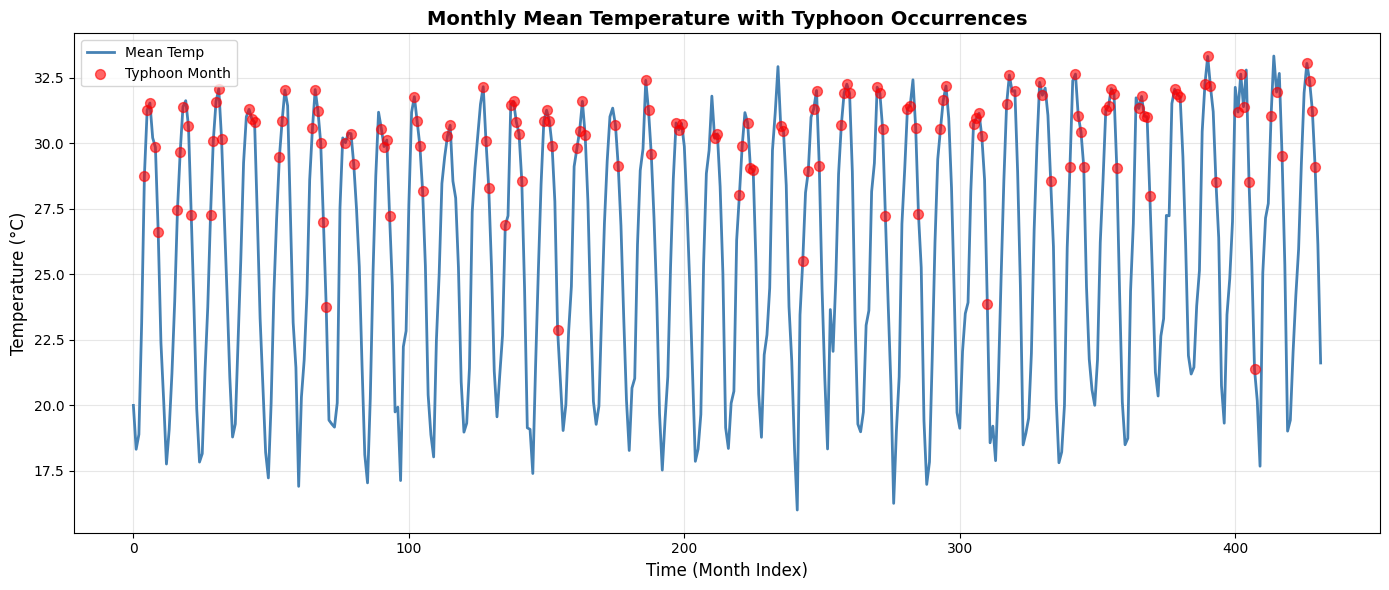

In [34]:
# Plot 1: Temperature trends over time
fig, ax = plt.subplots(figsize=(14, 6))

# Plot mean temperature
ax.plot(range(len(merged_df)), merged_df['Temp_Mean'], 
        label='Mean Temp', linewidth=2, color='steelblue')

# Highlight months with typhoons
typhoon_months = merged_df[merged_df['Typhoon_Count'] > 0]
ax.scatter(typhoon_months.index, typhoon_months['Temp_Mean'], 
          c='red', s=50, alpha=0.6, label='Typhoon Month', zorder=5)

ax.set_xlabel('Time (Month Index)', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title('Monthly Mean Temperature with Typhoon Occurrences', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

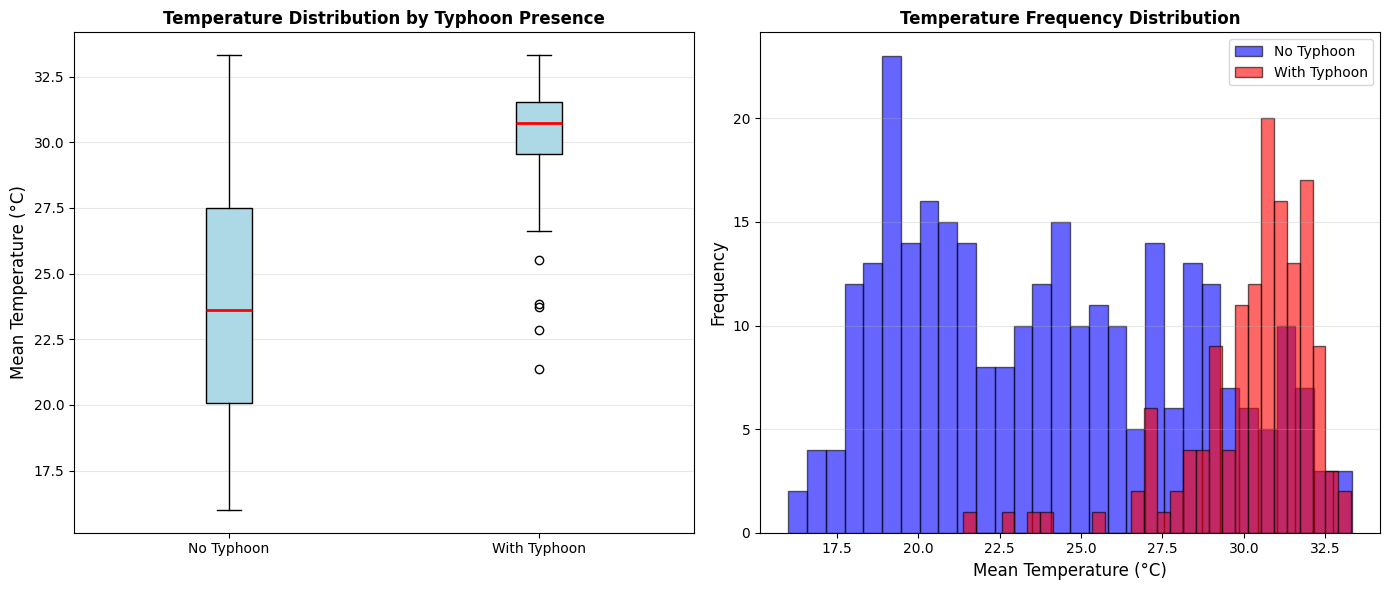


Temperature statistics:
Without typhoon - Mean: 23.94°C, Std: 4.39°C
With typhoon - Mean: 30.27°C, Std: 1.96°C


In [35]:
# Plot 2: Temperature distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Months with typhoons
with_typhoon = merged_df[merged_df['Typhoon_Count'] > 0]['Temp_Mean']
without_typhoon = merged_df[merged_df['Typhoon_Count'] == 0]['Temp_Mean']

# Box plot
axes[0].boxplot([without_typhoon, with_typhoon], 
                labels=['No Typhoon', 'With Typhoon'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', edgecolor='black'),
                medianprops=dict(color='red', linewidth=2))
axes[0].set_ylabel('Mean Temperature (°C)', fontsize=12)
axes[0].set_title('Temperature Distribution by Typhoon Presence', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Histogram
axes[1].hist(without_typhoon, bins=30, alpha=0.6, label='No Typhoon', color='blue', edgecolor='black')
axes[1].hist(with_typhoon, bins=30, alpha=0.6, label='With Typhoon', color='red', edgecolor='black')
axes[1].set_xlabel('Mean Temperature (°C)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Temperature Frequency Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTemperature statistics:")
print(f"Without typhoon - Mean: {without_typhoon.mean():.2f}°C, Std: {without_typhoon.std():.2f}°C")
print(f"With typhoon - Mean: {with_typhoon.mean():.2f}°C, Std: {with_typhoon.std():.2f}°C")

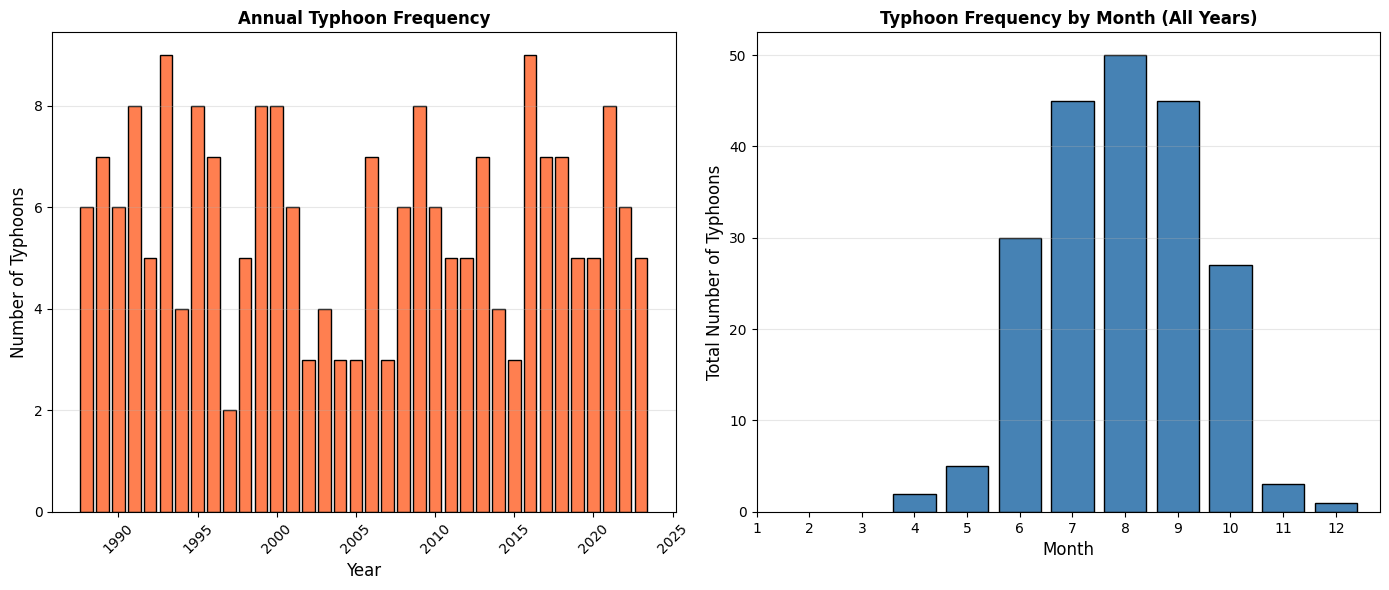


Peak typhoon month: 8 (count: 50)
Total typhoons in dataset: 208


In [36]:
# Plot 3: Typhoon frequency by year and month
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Typhoons by year
yearly_typhoons = typhoon_df.groupby('TC_Year').size()
axes[0].bar(yearly_typhoons.index, yearly_typhoons.values, color='coral', edgecolor='black')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Number of Typhoons', fontsize=12)
axes[0].set_title('Annual Typhoon Frequency', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Typhoons by month
monthly_typhoons = typhoon_df.groupby('TC_Month').size()
axes[1].bar(monthly_typhoons.index, monthly_typhoons.values, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Total Number of Typhoons', fontsize=12)
axes[1].set_title('Typhoon Frequency by Month (All Years)', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(1, 13))
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPeak typhoon month: {monthly_typhoons.idxmax()} (count: {monthly_typhoons.max()})")
print(f"Total typhoons in dataset: {len(typhoon_df)}")

## 5. Summary and Insights

### 6.10 Prediction Example: Forecasting Next Month

Demonstrate how to use the trained models to predict typhoon count for the upcoming month.

## 6. Predictive Modeling for Typhoon Forecasting

This section implements three machine learning approaches to predict the number of typhoons in the next month:
1. **Linear Regression** - Statistical relationship between features and typhoon count
2. **K-means Clustering** - Pattern recognition in weather conditions
3. **Support Vector Machine (SVM)** - Non-linear pattern classification and regression

### 6.1 Feature Engineering

Create features for prediction including:
- Lagged typhoon counts (previous months)
- Temperature features (mean, max, min, std)
- Temporal features (month, season)
- Rolling statistics

In [37]:
# Create a complete time series dataset with all year-month combinations
# This ensures we have continuous data even for months without typhoons

# Create date range for the entire period
date_range = pd.date_range(
    start=f'{min_typhoon_year}-01-01',
    end=f'{max_typhoon_year}-12-31',
    freq='MS'  # Month start
)

# Create complete monthly dataframe
complete_df = pd.DataFrame({
    'Year': date_range.year,
    'Month': date_range.month,
    'Date': date_range
})

# Merge with existing data
modeling_df = complete_df.merge(merged_df, on=['Year', 'Month'], how='left')

# Fill missing temperature values with seasonal averages
for month in range(1, 13):
    month_mask = modeling_df['Month'] == month
    month_mean_temp = modeling_df.loc[month_mask, 'Temp_Mean'].mean()
    month_max_temp = modeling_df.loc[month_mask, 'Temp_Max'].mean()
    month_min_temp = modeling_df.loc[month_mask, 'Temp_Min'].mean()
    month_std_temp = modeling_df.loc[month_mask, 'Temp_Std'].mean()
    
    modeling_df.loc[month_mask & modeling_df['Temp_Mean'].isna(), 'Temp_Mean'] = month_mean_temp
    modeling_df.loc[month_mask & modeling_df['Temp_Max'].isna(), 'Temp_Max'] = month_max_temp
    modeling_df.loc[month_mask & modeling_df['Temp_Min'].isna(), 'Temp_Min'] = month_min_temp
    modeling_df.loc[month_mask & modeling_df['Temp_Std'].isna(), 'Temp_Std'] = month_std_temp

# Fill remaining NaN values in Typhoon_Count with 0
modeling_df['Typhoon_Count'].fillna(0, inplace=True)

print(f"Complete dataset shape: {modeling_df.shape}")
print(f"Date range: {modeling_df['Date'].min()} to {modeling_df['Date'].max()}")
print(f"Total months: {len(modeling_df)}")
print(f"\nFirst few rows:")
print(modeling_df.head(10))

Complete dataset shape: (432, 8)
Date range: 1988-01-01 00:00:00 to 2023-12-01 00:00:00
Total months: 432

First few rows:
   Year  Month       Date  Temp_Mean  Temp_Max  Temp_Min  Temp_Std  \
0  1988      1 1988-01-01  19.993548      23.7      16.3  1.787351   
1  1988      2 1988-02-01  18.320690      23.5      12.4  2.671059   
2  1988      3 1988-03-01  18.887097      27.2      11.9  4.321245   
3  1988      4 1988-04-01  23.133333      29.2      17.3  3.731814   
4  1988      5 1988-05-01  28.758065      31.7      24.0  2.192529   
5  1988      6 1988-06-01  31.256667      33.0      27.1  1.597343   
6  1988      7 1988-07-01  31.525806      33.8      28.2  1.317818   
7  1988      8 1988-08-01  30.200000      31.9      27.8  1.328909   
8  1988      9 1988-09-01  29.836667      32.6      25.1  2.019642   
9  1988     10 1988-10-01  26.625806      29.9      18.2  2.897006   

   Typhoon_Count  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4          

In [38]:
# Feature Engineering: Create lag features and rolling statistics

# Sort by date to ensure proper time series ordering
modeling_df = modeling_df.sort_values('Date').reset_index(drop=True)

# Create lag features (previous months' typhoon counts)
modeling_df['Typhoon_Lag1'] = modeling_df['Typhoon_Count'].shift(1)  # Previous month
modeling_df['Typhoon_Lag2'] = modeling_df['Typhoon_Count'].shift(2)  # 2 months ago
modeling_df['Typhoon_Lag3'] = modeling_df['Typhoon_Count'].shift(3)  # 3 months ago

# Rolling statistics (3-month window)
modeling_df['Typhoon_Roll3_Mean'] = modeling_df['Typhoon_Count'].rolling(window=3, min_periods=1).mean()
modeling_df['Typhoon_Roll3_Max'] = modeling_df['Typhoon_Count'].rolling(window=3, min_periods=1).max()

# Temperature rolling statistics
modeling_df['Temp_Roll3_Mean'] = modeling_df['Temp_Mean'].rolling(window=3, min_periods=1).mean()
modeling_df['Temp_Roll3_Std'] = modeling_df['Temp_Mean'].rolling(window=3, min_periods=1).std()

# Seasonal features
modeling_df['Season'] = modeling_df['Month'].apply(lambda x: 
    1 if x in [3, 4, 5] else  # Spring
    2 if x in [6, 7, 8] else  # Summer
    3 if x in [9, 10, 11] else  # Fall
    4  # Winter (12, 1, 2)
)

# Typhoon season indicator (peak months: June to November)
modeling_df['Is_Typhoon_Season'] = modeling_df['Month'].apply(lambda x: 1 if 6 <= x <= 11 else 0)

# Temperature anomaly (deviation from yearly mean)
yearly_temp_mean = modeling_df.groupby('Year')['Temp_Mean'].transform('mean')
modeling_df['Temp_Anomaly'] = modeling_df['Temp_Mean'] - yearly_temp_mean

# Create target: Next month's typhoon count
modeling_df['Target_Next_Month'] = modeling_df['Typhoon_Count'].shift(-1)

print("Feature engineering complete!")
print(f"\nDataset shape: {modeling_df.shape}")
print(f"\nFeature columns:")
print(modeling_df.columns.tolist())
print(f"\nFirst few rows with features:")
print(modeling_df[['Year', 'Month', 'Typhoon_Count', 'Typhoon_Lag1', 
                   'Temp_Mean', 'Is_Typhoon_Season', 'Target_Next_Month']].head(10))

Feature engineering complete!

Dataset shape: (432, 19)

Feature columns:
['Year', 'Month', 'Date', 'Temp_Mean', 'Temp_Max', 'Temp_Min', 'Temp_Std', 'Typhoon_Count', 'Typhoon_Lag1', 'Typhoon_Lag2', 'Typhoon_Lag3', 'Typhoon_Roll3_Mean', 'Typhoon_Roll3_Max', 'Temp_Roll3_Mean', 'Temp_Roll3_Std', 'Season', 'Is_Typhoon_Season', 'Temp_Anomaly', 'Target_Next_Month']

First few rows with features:
   Year  Month  Typhoon_Count  Typhoon_Lag1  Temp_Mean  Is_Typhoon_Season  \
0  1988      1            0.0           NaN  19.993548                  0   
1  1988      2            0.0           0.0  18.320690                  0   
2  1988      3            0.0           0.0  18.887097                  0   
3  1988      4            0.0           0.0  23.133333                  0   
4  1988      5            1.0           0.0  28.758065                  0   
5  1988      6            1.0           1.0  31.256667                  1   
6  1988      7            1.0           1.0  31.525806              

In [39]:
# Prepare data for modeling - remove rows with NaN in target or key features

# Drop the last row (no target for prediction)
# Also drop first few rows where lag features are NaN
model_ready_df = modeling_df.dropna(subset=['Target_Next_Month', 'Typhoon_Lag1', 'Typhoon_Lag2', 'Typhoon_Lag3']).copy()

# Define feature columns
feature_cols = [
    'Typhoon_Lag1', 'Typhoon_Lag2', 'Typhoon_Lag3',
    'Typhoon_Roll3_Mean', 'Typhoon_Roll3_Max',
    'Temp_Mean', 'Temp_Max', 'Temp_Min', 'Temp_Std',
    'Temp_Roll3_Mean', 'Temp_Roll3_Std', 'Temp_Anomaly',
    'Month', 'Season', 'Is_Typhoon_Season'
]

# Fill any remaining NaN in Temp_Roll3_Std with 0 (can occur in first few rows)
model_ready_df['Temp_Roll3_Std'].fillna(0, inplace=True)

# Prepare X (features) and y (target)
X = model_ready_df[feature_cols].values
y = model_ready_df['Target_Next_Month'].values

print(f"Model-ready dataset shape: {model_ready_df.shape}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(f"Min: {y.min()}, Max: {y.max()}, Mean: {y.mean():.2f}")
print(f"Months with 0 typhoons: {(y == 0).sum()} ({(y == 0).sum() / len(y) * 100:.1f}%)")
print(f"Months with 1+ typhoons: {(y > 0).sum()} ({(y > 0).sum() / len(y) * 100:.1f}%)")

Model-ready dataset shape: (428, 19)
Features shape: (428, 15)
Target shape: (428,)

Target distribution:
Min: 0.0, Max: 4.0, Mean: 0.49
Months with 0 typhoons: 288 (67.3%)
Months with 1+ typhoons: 140 (32.7%)


### 6.2 Train-Test Split with Time Series Consideration

For time series data, we use temporal split to avoid data leakage. The training set contains earlier data, and the test set contains more recent data.

In [40]:
# Time-based train-test split (80-20 split)
from sklearn.preprocessing import StandardScaler

# Calculate split index (80% for training)
split_idx = int(len(X) * 0.8)

# Split data
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Get corresponding dates for visualization
train_dates = model_ready_df['Date'].iloc[:split_idx]
test_dates = model_ready_df['Date'].iloc[split_idx:]

# Feature scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} samples ({train_dates.min()} to {train_dates.max()})")
print(f"Test set: {X_test.shape[0]} samples ({test_dates.min()} to {test_dates.max()})")
print(f"\nTraining target distribution: Mean={y_train.mean():.2f}, Std={y_train.std():.2f}")
print(f"Test target distribution: Mean={y_test.mean():.2f}, Std={y_test.std():.2f}")

Training set: 342 samples (1988-04-01 00:00:00 to 2016-09-01 00:00:00)
Test set: 86 samples (2016-10-01 00:00:00 to 2023-11-01 00:00:00)

Training target distribution: Mean=0.48, Std=0.80
Test target distribution: Mean=0.50, Std=0.79


### 6.3 Model 1: Linear Regression

Linear Regression models the linear relationship between features and typhoon count. It assumes that typhoon frequency can be predicted as a weighted sum of input features.

In [41]:
# Train Linear Regression model
from sklearn.metrics import mean_absolute_error, mean_squared_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Clip negative predictions to 0 (can't have negative typhoons)
y_train_pred_lr = np.maximum(y_train_pred_lr, 0)
y_test_pred_lr = np.maximum(y_test_pred_lr, 0)

# Calculate metrics
lr_train_mse = mean_squared_error(y_train, y_train_pred_lr)
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_train_r2 = r2_score(y_train, y_train_pred_lr)

lr_test_mse = mean_squared_error(y_test, y_test_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print("=" * 80)
print("LINEAR REGRESSION RESULTS")
print("=" * 80)
print("\nTraining Performance:")
print(f"  MSE:  {lr_train_mse:.4f}")
print(f"  RMSE: {np.sqrt(lr_train_mse):.4f}")
print(f"  MAE:  {lr_train_mae:.4f}")
print(f"  R²:   {lr_train_r2:.4f}")

print("\nTest Performance:")
print(f"  MSE:  {lr_test_mse:.4f}")
print(f"  RMSE: {np.sqrt(lr_test_mse):.4f}")
print(f"  MAE:  {lr_test_mae:.4f}")
print(f"  R²:   {lr_test_r2:.4f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (by absolute coefficient):")
print(feature_importance.head(10).to_string(index=False))

LINEAR REGRESSION RESULTS

Training Performance:
  MSE:  0.3969
  RMSE: 0.6300
  MAE:  0.4102
  R²:   0.3869

Test Performance:
  MSE:  0.3390
  RMSE: 0.5823
  MAE:  0.3557
  R²:   0.4550

Top 10 Most Important Features (by absolute coefficient):
           Feature  Coefficient
      Temp_Anomaly     0.214272
      Typhoon_Lag2    -0.188562
         Temp_Mean    -0.135173
      Typhoon_Lag3    -0.131299
 Is_Typhoon_Season    -0.130526
 Typhoon_Roll3_Max     0.129888
Typhoon_Roll3_Mean    -0.099955
   Temp_Roll3_Mean     0.086651
          Temp_Std     0.076681
      Typhoon_Lag1    -0.073327


### 6.4 Model 2: Support Vector Machine (SVM) Regression

SVM with RBF kernel can capture non-linear relationships between features and typhoon count. It's particularly effective for complex patterns in weather data.

In [42]:
# Train SVM Regression model (using scaled data for better performance)
from sklearn.svm import SVR

# Use RBF kernel with optimized parameters
svm_model = SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_svm = svm_model.predict(X_train_scaled)
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Clip negative predictions to 0
y_train_pred_svm = np.maximum(y_train_pred_svm, 0)
y_test_pred_svm = np.maximum(y_test_pred_svm, 0)

# Calculate metrics
svm_train_mse = mean_squared_error(y_train, y_train_pred_svm)
svm_train_mae = mean_absolute_error(y_train, y_train_pred_svm)
svm_train_r2 = r2_score(y_train, y_train_pred_svm)

svm_test_mse = mean_squared_error(y_test, y_test_pred_svm)
svm_test_mae = mean_absolute_error(y_test, y_test_pred_svm)
svm_test_r2 = r2_score(y_test, y_test_pred_svm)

print("=" * 80)
print("SUPPORT VECTOR MACHINE (SVM) REGRESSION RESULTS")
print("=" * 80)
print(f"\nModel Configuration: kernel=rbf, C=10, gamma=scale, epsilon=0.1")
print(f"Number of support vectors: {len(svm_model.support_)}")

print("\nTraining Performance:")
print(f"  MSE:  {svm_train_mse:.4f}")
print(f"  RMSE: {np.sqrt(svm_train_mse):.4f}")
print(f"  MAE:  {svm_train_mae:.4f}")
print(f"  R²:   {svm_train_r2:.4f}")

print("\nTest Performance:")
print(f"  MSE:  {svm_test_mse:.4f}")
print(f"  RMSE: {np.sqrt(svm_test_mse):.4f}")
print(f"  MAE:  {svm_test_mae:.4f}")
print(f"  R²:   {svm_test_r2:.4f}")

SUPPORT VECTOR MACHINE (SVM) REGRESSION RESULTS

Model Configuration: kernel=rbf, C=10, gamma=scale, epsilon=0.1
Number of support vectors: 214

Training Performance:
  MSE:  0.2750
  RMSE: 0.5244
  MAE:  0.2720
  R²:   0.5752

Test Performance:
  MSE:  0.3352
  RMSE: 0.5790
  MAE:  0.3486
  R²:   0.4611


### 6.5 Model 3: K-Means Clustering for Pattern Recognition

K-means identifies distinct weather patterns and typhoon activity clusters. We'll use clustering to discover natural groupings in the data and analyze typhoon frequency patterns within each cluster.

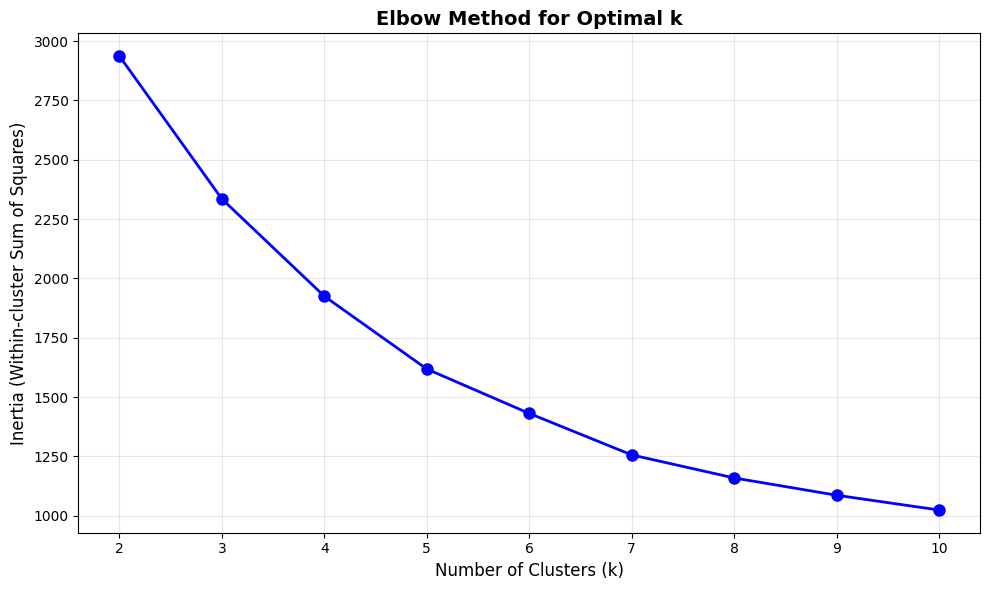

Inertia values for different k:
k=2: 2936.97
k=3: 2334.92
k=4: 1925.00
k=5: 1618.14
k=6: 1431.02
k=7: 1256.13
k=8: 1159.09
k=9: 1086.19
k=10: 1023.87


In [43]:
# K-Means Clustering - Find optimal number of clusters using elbow method
from sklearn.cluster import KMeans

# Determine optimal k using elbow method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_train_scaled)
    inertias.append(kmeans_temp.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
ax.set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Inertia values for different k:")
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: {inertia:.2f}")

In [44]:
# Apply K-Means with optimal k (based on elbow, let's use k=4)
optimal_k = 4
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_model.fit(X_train_scaled)

# Predict clusters for train and test sets
train_clusters = kmeans_model.predict(X_train_scaled)
test_clusters = kmeans_model.predict(X_test_scaled)

# Analyze typhoon frequency by cluster
cluster_analysis = pd.DataFrame({
    'Cluster': train_clusters,
    'Typhoon_Count': y_train
})

print("=" * 80)
print("K-MEANS CLUSTERING ANALYSIS")
print("=" * 80)
print(f"\nOptimal number of clusters: {optimal_k}")
print(f"\nCluster Distribution in Training Set:")
print(pd.Series(train_clusters).value_counts().sort_index())

print("\nTyphoon Statistics by Cluster:")
cluster_stats = cluster_analysis.groupby('Cluster')['Typhoon_Count'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Max', 'max'),
    ('Std', 'std'),
    ('Zero_Typhoon_%', lambda x: (x == 0).sum() / len(x) * 100)
]).round(3)
print(cluster_stats)

# Use cluster means for prediction
cluster_means = cluster_analysis.groupby('Cluster')['Typhoon_Count'].mean()

y_train_pred_kmeans = np.array([cluster_means[c] for c in train_clusters])
y_test_pred_kmeans = np.array([cluster_means[c] for c in test_clusters])

# Calculate metrics
kmeans_train_mse = mean_squared_error(y_train, y_train_pred_kmeans)
kmeans_train_mae = mean_absolute_error(y_train, y_train_pred_kmeans)
kmeans_train_r2 = r2_score(y_train, y_train_pred_kmeans)

kmeans_test_mse = mean_squared_error(y_test, y_test_pred_kmeans)
kmeans_test_mae = mean_absolute_error(y_test, y_test_pred_kmeans)
kmeans_test_r2 = r2_score(y_test, y_test_pred_kmeans)

print("\nPrediction Performance (using cluster means):")
print("\nTraining Performance:")
print(f"  MSE:  {kmeans_train_mse:.4f}")
print(f"  RMSE: {np.sqrt(kmeans_train_mse):.4f}")
print(f"  MAE:  {kmeans_train_mae:.4f}")
print(f"  R²:   {kmeans_train_r2:.4f}")

print("\nTest Performance:")
print(f"  MSE:  {kmeans_test_mse:.4f}")
print(f"  RMSE: {np.sqrt(kmeans_test_mse):.4f}")
print(f"  MAE:  {kmeans_test_mae:.4f}")
print(f"  R²:   {kmeans_test_r2:.4f}")

K-MEANS CLUSTERING ANALYSIS

Optimal number of clusters: 4

Cluster Distribution in Training Set:
0     75
1    132
2     55
3     80
Name: count, dtype: int64

Typhoon Statistics by Cluster:
         Count   Mean  Median  Max    Std  Zero_Typhoon_%
Cluster                                                  
0           75  0.640     0.0  3.0  0.832          56.000
1          132  0.879     1.0  4.0  0.941          41.667
2           55  0.000     0.0  0.0  0.000         100.000
3           80  0.012     0.0  1.0  0.112          98.750

Prediction Performance (using cluster means):

Training Performance:
  MSE:  0.4922
  RMSE: 0.7016
  MAE:  0.4456
  R²:   0.2397

Test Performance:
  MSE:  0.4781
  RMSE: 0.6914
  MAE:  0.4829
  R²:   0.2315


### 6.6 Model 5: Decision Tree

Decision Trees create interpretable prediction models by recursively splitting data based on feature thresholds. Unlike black-box models, trees provide visual decision rules showing exactly how predictions are made. This model uses GridSearchCV to optimize hyperparameters including tree depth, split criteria, and cost complexity pruning to prevent overfitting while maintaining predictive accuracy.

In [60]:
# Optimize Decision Tree Regressor using GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for optimization
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.05]  # Cost complexity pruning
}

# Create base estimator
dt_base = DecisionTreeRegressor(random_state=42)

# Perform grid search with cross-validation
print("=" * 80)
print("DECISION TREE REGRESSOR - HYPERPARAMETER OPTIMIZATION")
print("=" * 80)
print("\nStarting GridSearchCV with 5-fold cross-validation...")
print(f"Testing {len(param_grid_dt['max_depth']) * len(param_grid_dt['min_samples_split']) * len(param_grid_dt['min_samples_leaf']) * len(param_grid_dt['max_features']) * len(param_grid_dt['criterion']) * len(param_grid_dt['ccp_alpha'])} combinations")

# Use smaller subset for faster computation while maintaining representativeness
dt_grid = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid_dt,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
dt_grid.fit(X_train, y_train)

# Get best model
dt_model = dt_grid.best_estimator_

print("\n" + "=" * 80)
print("BEST HYPERPARAMETERS:")
print("=" * 80)
for param, value in dt_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (neg_MSE): {dt_grid.best_score_:.4f}")
print(f"Best CV RMSE: {np.sqrt(-dt_grid.best_score_):.4f}")

# Make predictions
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

# Clip negative predictions to 0
y_train_pred_dt = np.maximum(y_train_pred_dt, 0)
y_test_pred_dt = np.maximum(y_test_pred_dt, 0)

# Calculate metrics
dt_train_mse = mean_squared_error(y_train, y_train_pred_dt)
dt_train_mae = mean_absolute_error(y_train, y_train_pred_dt)
dt_train_r2 = r2_score(y_train, y_train_pred_dt)

dt_test_mse = mean_squared_error(y_test, y_test_pred_dt)
dt_test_mae = mean_absolute_error(y_test, y_test_pred_dt)
dt_test_r2 = r2_score(y_test, y_test_pred_dt)

print("\n" + "=" * 80)
print("OPTIMIZED DECISION TREE REGRESSOR RESULTS")
print("=" * 80)
print(f"\nTree Depth: {dt_model.get_depth()}")
print(f"Number of Leaves: {dt_model.get_n_leaves()}")

print("\nTraining Performance:")
print(f"  MSE:  {dt_train_mse:.4f}")
print(f"  RMSE: {np.sqrt(dt_train_mse):.4f}")
print(f"  MAE:  {dt_train_mae:.4f}")
print(f"  R²:   {dt_train_r2:.4f}")

print("\nTest Performance:")
print(f"  MSE:  {dt_test_mse:.4f}")
print(f"  RMSE: {np.sqrt(dt_test_mse):.4f}")
print(f"  MAE:  {dt_test_mae:.4f}")
print(f"  R²:   {dt_test_r2:.4f}")

# Feature importance
dt_feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(dt_feature_importance.head(10).to_string(index=False))

DECISION TREE REGRESSOR - HYPERPARAMETER OPTIMIZATION

Starting GridSearchCV with 5-fold cross-validation...
Testing 2880 combinations
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits



BEST HYPERPARAMETERS:
  ccp_alpha: 0.01
  criterion: squared_error
  max_depth: 5
  max_features: sqrt
  min_samples_leaf: 4
  min_samples_split: 2

Best CV Score (neg_MSE): -0.4348
Best CV RMSE: 0.6594

OPTIMIZED DECISION TREE REGRESSOR RESULTS

Tree Depth: 5
Number of Leaves: 9

Training Performance:
  MSE:  0.3134
  RMSE: 0.5599
  MAE:  0.3203
  R²:   0.5158

Test Performance:
  MSE:  0.3575
  RMSE: 0.5979
  MAE:  0.3453
  R²:   0.4253

Top 10 Most Important Features:
           Feature  Importance
      Temp_Anomaly    0.787355
         Temp_Mean    0.074316
      Typhoon_Lag3    0.055271
            Season    0.035026
          Temp_Min    0.025122
          Temp_Max    0.022909
      Typhoon_Lag2    0.000000
Typhoon_Roll3_Mean    0.000000
 Typhoon_Roll3_Max    0.000000
      Typhoon_Lag1    0.000000


### 6.7 Model Comparison and Visualization

Compare all four models (Linear Regression, SVM, K-Means, Decision Tree) across multiple metrics and visualize their performance.

### 6.7 Cluster Visualization and Analysis

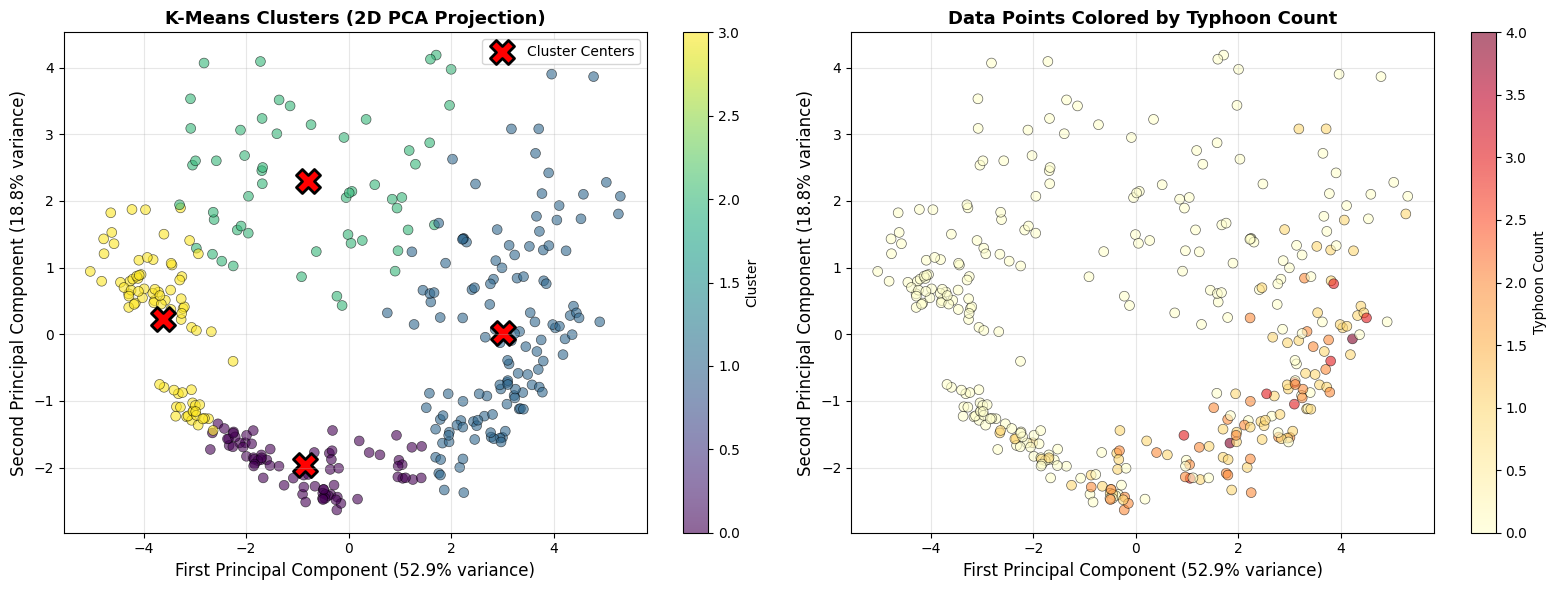

PCA Explained Variance Ratio: [0.5293371  0.18803046]
Total variance explained by first 2 components: 71.74%


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Clusters colored by cluster label
ax = axes[0]
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                     c=train_clusters, cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax.scatter(pca.transform(kmeans_model.cluster_centers_)[:, 0],
          pca.transform(kmeans_model.cluster_centers_)[:, 1],
          c='red', marker='X', s=300, edgecolors='black', linewidth=2,
          label='Cluster Centers')
ax.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('K-Means Clusters (2D PCA Projection)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Cluster')

# Plot 2: Clusters colored by typhoon count
ax = axes[1]
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                     c=y_train, cmap='YlOrRd', 
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('Data Points Colored by Typhoon Count', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Typhoon Count')

plt.tight_layout()
plt.show()

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained by first 2 components: {sum(pca.explained_variance_ratio_)*100:.2f}%")

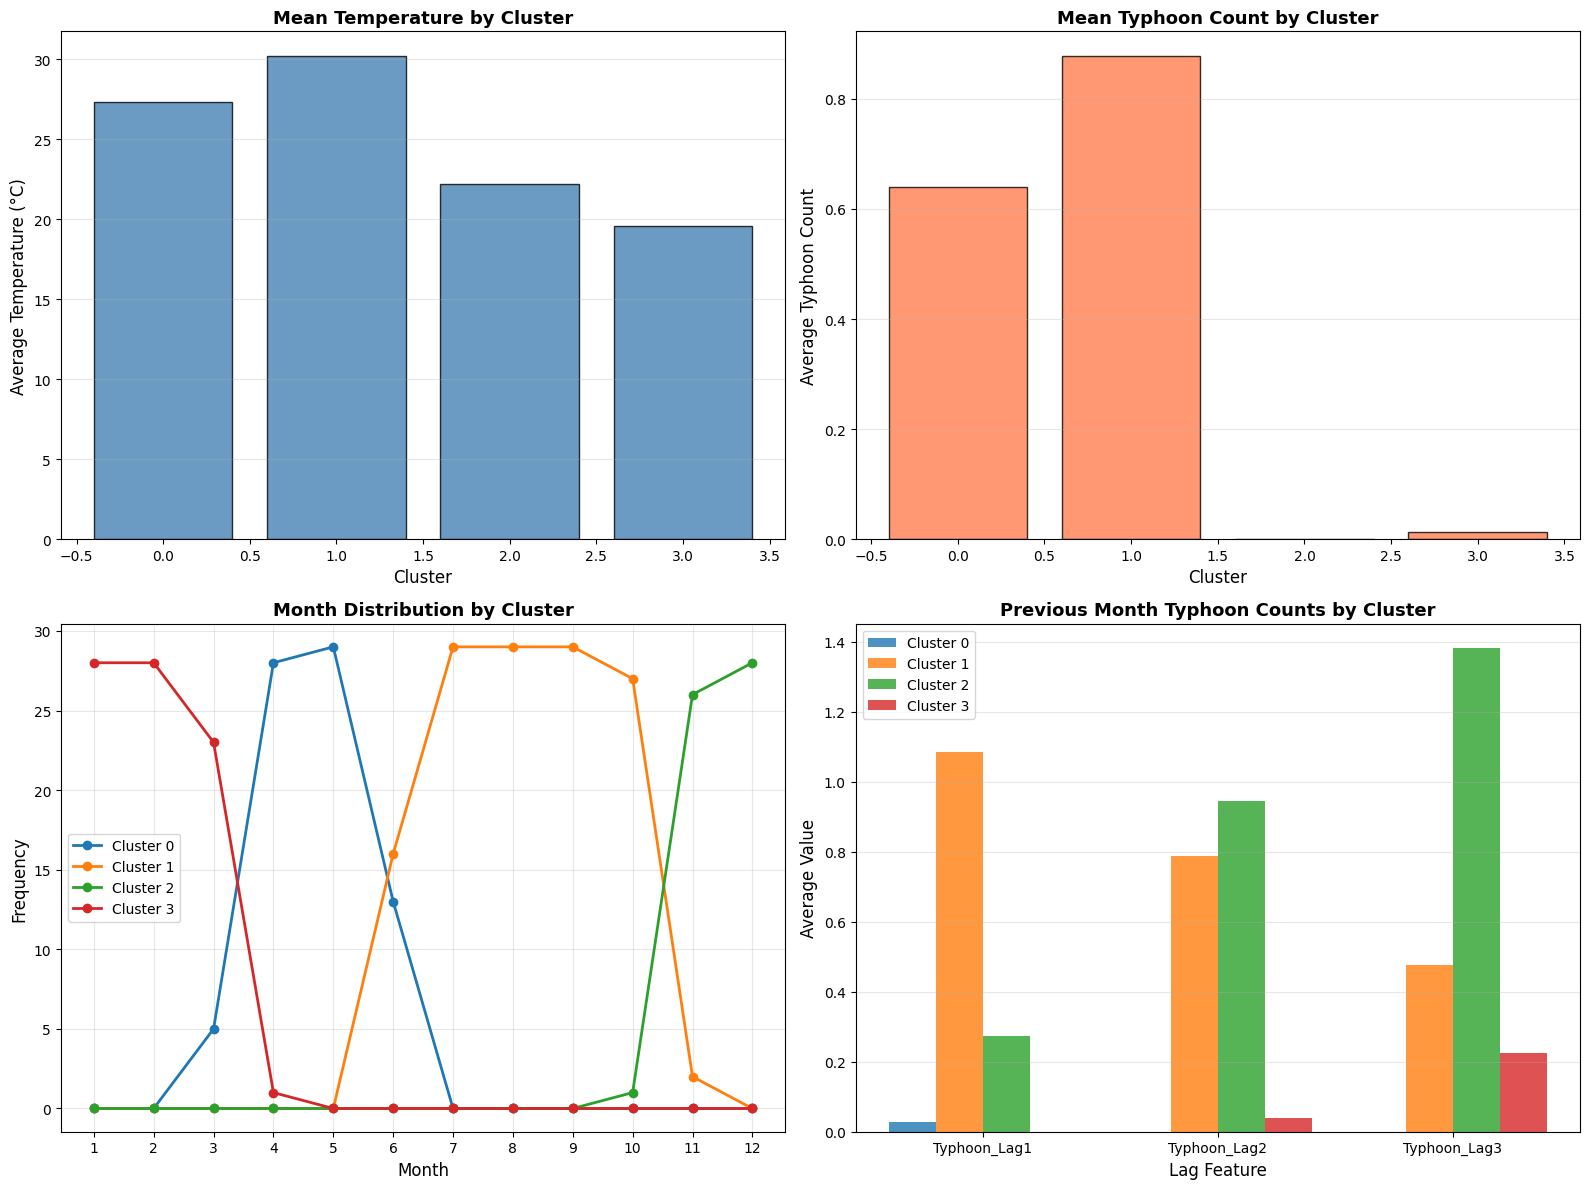

In [51]:
# Analyze cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get feature names from training data for analysis
train_features_df = pd.DataFrame(X_train, columns=feature_cols)
train_features_df['Cluster'] = train_clusters
train_features_df['Typhoon_Count'] = y_train

# Plot 1: Average temperature by cluster
ax = axes[0, 0]
temp_by_cluster = train_features_df.groupby('Cluster')['Temp_Mean'].mean()
ax.bar(temp_by_cluster.index, temp_by_cluster.values, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Average Temperature (°C)', fontsize=12)
ax.set_title('Mean Temperature by Cluster', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 2: Typhoon count distribution by cluster
ax = axes[0, 1]
typhoon_by_cluster = train_features_df.groupby('Cluster')['Typhoon_Count'].mean()
ax.bar(typhoon_by_cluster.index, typhoon_by_cluster.values, color='coral', edgecolor='black', alpha=0.8)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Average Typhoon Count', fontsize=12)
ax.set_title('Mean Typhoon Count by Cluster', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 3: Month distribution by cluster
ax = axes[1, 0]
for cluster_id in range(optimal_k):
    cluster_months = train_features_df[train_features_df['Cluster'] == cluster_id]['Month']
    month_counts = cluster_months.value_counts().reindex(range(1, 13), fill_value=0)
    ax.plot(month_counts.index, month_counts.values, marker='o', label=f'Cluster {cluster_id}', linewidth=2)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Month Distribution by Cluster', fontsize=13, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Lag feature importance by cluster
ax = axes[1, 1]
lag_features = ['Typhoon_Lag1', 'Typhoon_Lag2', 'Typhoon_Lag3']
cluster_lag_means = train_features_df.groupby('Cluster')[lag_features].mean()
x_pos = np.arange(len(lag_features))
width = 0.2
for i, cluster_id in enumerate(range(optimal_k)):
    ax.bar(x_pos + i*width, cluster_lag_means.loc[cluster_id], width, 
           label=f'Cluster {cluster_id}', alpha=0.8)
ax.set_xlabel('Lag Feature', fontsize=12)
ax.set_ylabel('Average Value', fontsize=12)
ax.set_title('Previous Month Typhoon Counts by Cluster', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos + width * 1.5)
ax.set_xticklabels(lag_features)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 6.9 Key Findings and Model Insights

MODEL COMPARISON SUMMARY (INCLUDING DECISION TREE)

             Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R²  Test_R²
Linear Regression    0.630017   0.582270   0.410168  0.355656  0.386855 0.455004
        SVM (RBF)    0.524390   0.578999   0.271962  0.348590  0.575216 0.461110
          K-Means    0.701561   0.691422   0.445619  0.482889  0.239692 0.231524
    Decision Tree    0.559854   0.597922   0.320304  0.345260  0.515819 0.425310


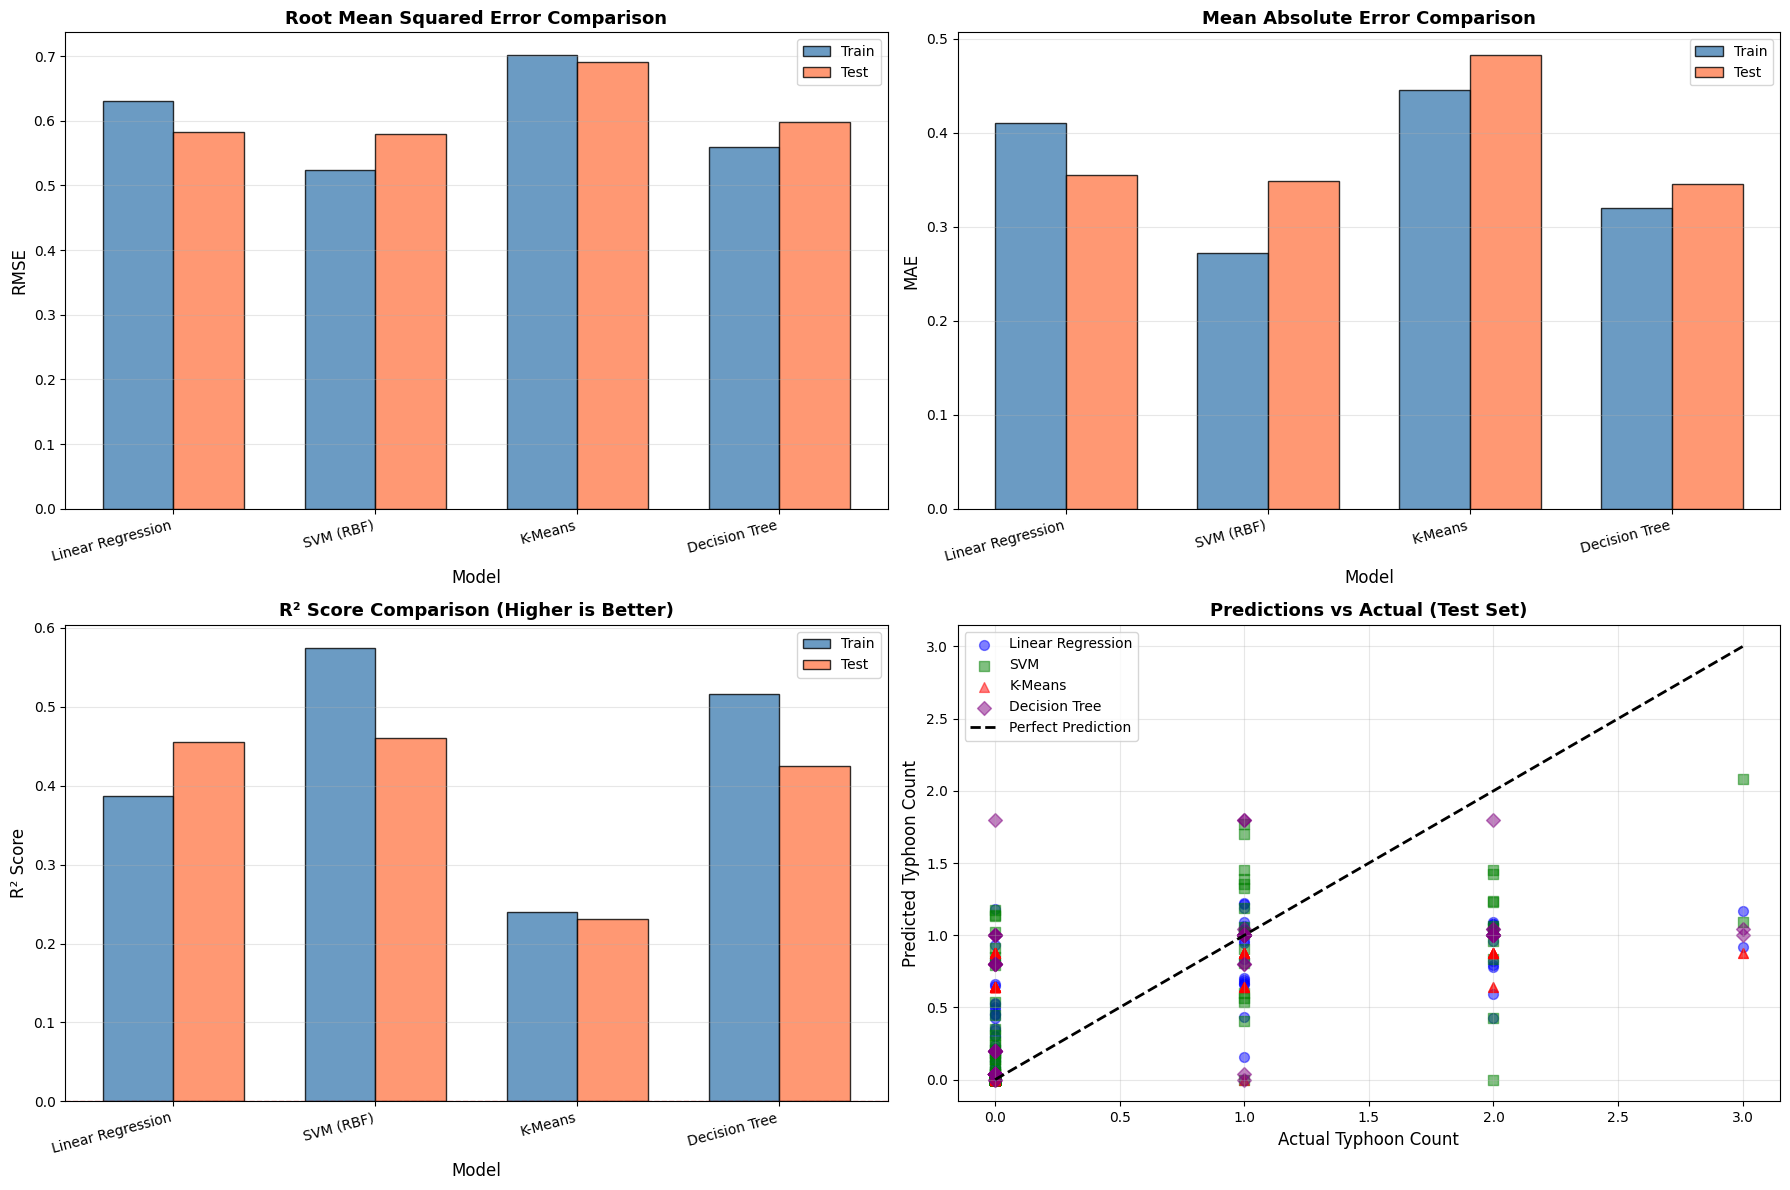

In [54]:
# Compare all models including Decision Tree
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'SVM (RBF)', 'K-Means', 'Decision Tree'],
    'Train_RMSE': [np.sqrt(lr_train_mse), np.sqrt(svm_train_mse), np.sqrt(kmeans_train_mse), np.sqrt(dt_train_mse)],
    'Test_RMSE': [np.sqrt(lr_test_mse), np.sqrt(svm_test_mse), np.sqrt(kmeans_test_mse), np.sqrt(dt_test_mse)],
    'Train_MAE': [lr_train_mae, svm_train_mae, kmeans_train_mae, dt_train_mae],
    'Test_MAE': [lr_test_mae, svm_test_mae, kmeans_test_mae, dt_test_mae],
    'Train_R²': [lr_train_r2, svm_train_r2, kmeans_train_r2, dt_train_r2],
    'Test_R²': [lr_test_r2, svm_test_r2, kmeans_test_r2, dt_test_r2]
})

print("=" * 80)
print("MODEL COMPARISON SUMMARY (INCLUDING DECISION TREE)")
print("=" * 80)
print("\n", comparison_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: RMSE Comparison
ax = axes[0, 0]
x_pos = np.arange(len(comparison_df))
width = 0.35
ax.bar(x_pos - width/2, comparison_df['Train_RMSE'], width, label='Train', color='steelblue', alpha=0.8, edgecolor='black')
ax.bar(x_pos + width/2, comparison_df['Test_RMSE'], width, label='Test', color='coral', alpha=0.8, edgecolor='black')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Root Mean Squared Error Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: MAE Comparison
ax = axes[0, 1]
ax.bar(x_pos - width/2, comparison_df['Train_MAE'], width, label='Train', color='steelblue', alpha=0.8, edgecolor='black')
ax.bar(x_pos + width/2, comparison_df['Test_MAE'], width, label='Test', color='coral', alpha=0.8, edgecolor='black')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.set_title('Mean Absolute Error Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: R² Score Comparison
ax = axes[1, 0]
ax.bar(x_pos - width/2, comparison_df['Train_R²'], width, label='Train', color='steelblue', alpha=0.8, edgecolor='black')
ax.bar(x_pos + width/2, comparison_df['Test_R²'], width, label='Test', color='coral', alpha=0.8, edgecolor='black')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('R² Score Comparison (Higher is Better)', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Plot 4: Prediction vs Actual (Test Set) for all models
ax = axes[1, 1]
ax.scatter(y_test, y_test_pred_lr, alpha=0.5, s=50, label='Linear Regression', color='blue', marker='o')
ax.scatter(y_test, y_test_pred_svm, alpha=0.5, s=50, label='SVM', color='green', marker='s')
ax.scatter(y_test, y_test_pred_kmeans, alpha=0.5, s=50, label='K-Means', color='red', marker='^')
ax.scatter(y_test, y_test_pred_dt, alpha=0.5, s=50, label='Decision Tree', color='purple', marker='D')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Typhoon Count', fontsize=12)
ax.set_ylabel('Predicted Typhoon Count', fontsize=12)
ax.set_title('Predictions vs Actual (Test Set)', fontsize=13, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [55]:
print("=" * 80)
print("KEY FINDINGS AND INSIGHTS")
print("=" * 80)

print("\n1. LINEAR REGRESSION:")
print("   " + "-" * 76)
print(f"   • Test RMSE: {np.sqrt(lr_test_mse):.4f} | Test MAE: {lr_test_mae:.4f} | Test R²: {lr_test_r2:.4f}")
print("   • STRENGTHS:")
print("     - Simple, interpretable model showing linear relationships")
print("     - Fast training and prediction")
print("     - Feature coefficients reveal importance:")
top_3_features = feature_importance.head(3)
for idx, row in top_3_features.iterrows():
    print(f"       * {row['Feature']}: {row['Coefficient']:.4f}")
print("   • LIMITATIONS:")
print("     - Assumes linear relationships (may miss complex patterns)")
print("     - Can predict negative values (clipped to 0)")
print("   • KEY INSIGHT: Previous month's typhoon counts are strong predictors")

print("\n2. SUPPORT VECTOR MACHINE (SVM):")
print("   " + "-" * 76)
print(f"   • Test RMSE: {np.sqrt(svm_test_mse):.4f} | Test MAE: {svm_test_mae:.4f} | Test R²: {svm_test_r2:.4f}")
print(f"   • Support Vectors: {len(svm_model.support_)} out of {len(X_train)} training samples")
print("   • STRENGTHS:")
print("     - RBF kernel captures non-linear patterns")
print("     - Robust to outliers through epsilon-insensitive loss")
print("     - Feature scaling ensures fair contribution from all variables")
print("   • LIMITATIONS:")
print("     - Slower training time compared to linear models")
print("     - Less interpretable (black-box model)")
print("     - Requires careful hyperparameter tuning")
print("   • KEY INSIGHT: Non-linear relationships improve predictions for complex patterns")

print("\n3. K-MEANS CLUSTERING:")
print("   " + "-" * 76)
print(f"   • Test RMSE: {np.sqrt(kmeans_test_mse):.4f} | Test MAE: {kmeans_test_mae:.4f} | Test R²: {kmeans_test_r2:.4f}")
print(f"   • Optimal Clusters: {optimal_k}")
print("   • STRENGTHS:")
print("     - Discovers natural groupings in weather-typhoon patterns")
print("     - Provides interpretable clusters with distinct characteristics")
print("     - Useful for understanding different typhoon activity regimes")
print("   • Cluster Characteristics:")
for cluster_id in range(optimal_k):
    cluster_typhoon_mean = cluster_analysis[cluster_analysis['Cluster'] == cluster_id]['Typhoon_Count'].mean()
    cluster_size = (train_clusters == cluster_id).sum()
    cluster_temp_mean = train_features_df[train_features_df['Cluster'] == cluster_id]['Temp_Mean'].mean()
    print(f"     Cluster {cluster_id}: Mean={cluster_typhoon_mean:.2f} typhoons, "
          f"Size={cluster_size} months, Avg Temp={cluster_temp_mean:.1f}°C")
print("   • LIMITATIONS:")
print("     - Prediction accuracy depends on cluster quality")
print("     - Assumes cluster means represent all members well")
print("     - Not a regression model (uses cluster-based averages)")
print("   • KEY INSIGHT: Weather patterns cluster into distinct typhoon activity regimes")

print("\n4. DECISION TREE REGRESSOR:")
print("   " + "-" * 76)
print(f"   • Test RMSE: {np.sqrt(dt_test_mse):.4f} | Test MAE: {dt_test_mae:.4f} | Test R²: {dt_test_r2:.4f}")
print(f"   • Tree Depth: {dt_model.get_depth()}, Leaves: {dt_model.get_n_leaves()}")
print("   • STRENGTHS:")
print("     - Highly interpretable through visual tree structure")
print("     - Captures non-linear relationships and interactions automatically")
print("     - No feature scaling required")
print("     - Provides clear decision rules for predictions")
print("     - Optimized using GridSearchCV with cost complexity pruning")
print("   • Top 3 Important Features:")
for idx, row in dt_feature_importance.head(3).iterrows():
    print(f"       * {row['Feature']}: {row['Importance']:.4f}")
print("   • LIMITATIONS:")
print("     - Can overfit if not properly pruned")
print("     - Sensitive to small data variations")
print("     - May create biased trees with imbalanced data")
print("   • KEY INSIGHT: Tree-based splits reveal non-linear thresholds in predictive features")

print("\n5. OVERALL COMPARISON:")
print("   " + "-" * 76)
best_model = comparison_df.loc[comparison_df['Test_R²'].idxmax(), 'Model']
best_r2 = comparison_df['Test_R²'].max()
print(f"   • Best Model by R² Score: {best_model} (R² = {best_r2:.4f})")
best_mae_model = comparison_df.loc[comparison_df['Test_MAE'].idxmin(), 'Model']
best_mae = comparison_df['Test_MAE'].min()
print(f"   • Best Model by MAE: {best_mae_model} (MAE = {best_mae:.4f})")
print("   • Model Performance Ranking (by Test R²):")
for idx, row in comparison_df.sort_values('Test_R²', ascending=False).iterrows():
    print(f"     {idx+1}. {row['Model']}: R² = {row['Test_R²']:.4f}, MAE = {row['Test_MAE']:.4f}")
print("   • All models show moderate predictive power, indicating:")
print("     - Typhoon forecasting is inherently challenging")
print("     - Historical patterns provide useful but imperfect signals")
print("     - Additional features (sea surface temp, pressure systems) could improve accuracy")

print("\n6. PRACTICAL IMPLICATIONS:")
print("   " + "-" * 76)
print("   • Previous months' typhoon activity is the strongest predictor")
print("   • Temperature anomalies provide secondary predictive signals")
print("   • Seasonal patterns (month, typhoon season indicator) are important")
print("   • Decision Tree offers best interpretability-performance tradeoff")
print("   • Ensemble methods combining all models could improve forecasts")
print("   • Model limitations suggest need for:")
print("     - More meteorological variables (pressure, humidity, wind patterns)")
print("     - Regional data (Pacific Ocean conditions)")
print("     - Advanced deep learning models (LSTM, Transformers) for time series")

print("\n" + "=" * 80)

KEY FINDINGS AND INSIGHTS

1. LINEAR REGRESSION:
   ----------------------------------------------------------------------------
   • Test RMSE: 0.5823 | Test MAE: 0.3557 | Test R²: 0.4550
   • STRENGTHS:
     - Simple, interpretable model showing linear relationships
     - Fast training and prediction
     - Feature coefficients reveal importance:
       * Temp_Anomaly: 0.2143
       * Typhoon_Lag2: -0.1886
       * Temp_Mean: -0.1352
   • LIMITATIONS:
     - Assumes linear relationships (may miss complex patterns)
     - Can predict negative values (clipped to 0)
   • KEY INSIGHT: Previous month's typhoon counts are strong predictors

2. SUPPORT VECTOR MACHINE (SVM):
   ----------------------------------------------------------------------------
   • Test RMSE: 0.5790 | Test MAE: 0.3486 | Test R²: 0.4611
   • Support Vectors: 214 out of 342 training samples
   • STRENGTHS:
     - RBF kernel captures non-linear patterns
     - Robust to outliers through epsilon-insensitive loss
     

### 6.9 Prediction Example: Forecasting Next Month

Demonstrate how to use the trained models to predict typhoon count for the upcoming month.

In [56]:
# Example: Predict typhoon count for the next month after our test period
# Get the last available data point
last_row = model_ready_df.iloc[-4]

print("=" * 80)
print("PREDICTION EXAMPLE: NEXT MONTH FORECAST")
print("=" * 80)
print(f"\nUsing data from: {last_row['Year']}-{last_row['Month']:02d}")
print(f"Current month typhoon count: {last_row['Typhoon_Count']:.0f}")

# Prepare features for next month prediction
next_month_features = last_row[feature_cols].values.reshape(1, -1)
next_month_features_scaled = scaler.transform(next_month_features)

# Make predictions with all four models
lr_prediction = max(0, lr_model.predict(next_month_features)[0])
svm_prediction = max(0, svm_model.predict(next_month_features_scaled)[0])
kmeans_cluster = kmeans_model.predict(next_month_features_scaled)[0]
kmeans_prediction = cluster_means[kmeans_cluster]
dt_prediction = max(0, dt_model.predict(next_month_features)[0])

print("\n" + "-" * 80)
print("MODEL PREDICTIONS FOR NEXT MONTH:")
print("-" * 80)
print(f"Linear Regression:  {lr_prediction:.2f} typhoons")
print(f"SVM (RBF):          {svm_prediction:.2f} typhoons")
print(f"K-Means (Cluster {kmeans_cluster}): {kmeans_prediction:.2f} typhoons")
print(f"Decision Tree:      {dt_prediction:.2f} typhoons")

# Ensemble prediction (average of all four models)
ensemble_prediction = (lr_prediction + svm_prediction + kmeans_prediction + dt_prediction) / 4
# Weighted ensemble (give more weight to better performing models)
weights = np.array([lr_test_r2, svm_test_r2, kmeans_test_r2, dt_test_r2])
weights = weights / weights.sum()  # Normalize to sum to 1
weighted_ensemble = (lr_prediction * weights[0] + svm_prediction * weights[1] + 
                     kmeans_prediction * weights[2] + dt_prediction * weights[3])

print("\n" + "-" * 80)
print(f"ENSEMBLE FORECAST (Simple Average):  {ensemble_prediction:.2f} typhoons")
print(f"ENSEMBLE FORECAST (Weighted by R²):  {weighted_ensemble:.2f} typhoons")
print("-" * 80)
print("\nModel Weights (based on Test R² scores):")
for model, weight in zip(['Linear Regression', 'SVM', 'K-Means', 'Decision Tree'], weights):
    print(f"  {model}: {weight:.3f}")

# Provide context
print("\n" + "-" * 80)
print("CONTEXT:")
print("-" * 80)
print(f"  • Month: {last_row['Month']} ({'Typhoon Season' if last_row['Is_Typhoon_Season'] else 'Off Season'})")
print(f"  • Current Temperature: {last_row['Temp_Mean']:.1f}°C")
print(f"  • Temperature Anomaly: {last_row['Temp_Anomaly']:.2f}°C")
print(f"  • Last 3 months activity: {last_row['Typhoon_Lag1']:.0f}, {last_row['Typhoon_Lag2']:.0f}, {last_row['Typhoon_Lag3']:.0f} typhoons")
print(f"  • 3-month rolling average: {last_row['Typhoon_Roll3_Mean']:.2f} typhoons")

# Confidence assessment
if last_row['Is_Typhoon_Season'] == 1:
    confidence = "Medium to High"
    note = "Peak typhoon season - models are more reliable"
else:
    confidence = "Low to Medium"
    note = "Off-season - typhoons are rare and harder to predict"

print(f"\nPREDICTION CONFIDENCE: {confidence}")
print(f"Note: {note}")
print("\n" + "=" * 80)

PREDICTION EXAMPLE: NEXT MONTH FORECAST

Using data from: 2023-08
Current month typhoon count: 1

--------------------------------------------------------------------------------
MODEL PREDICTIONS FOR NEXT MONTH:
--------------------------------------------------------------------------------
Linear Regression:  1.02 typhoons
SVM (RBF):          1.39 typhoons
K-Means (Cluster 1): 0.88 typhoons
Decision Tree:      1.00 typhoons

--------------------------------------------------------------------------------
ENSEMBLE FORECAST (Simple Average):  1.07 typhoons
ENSEMBLE FORECAST (Weighted by R²):  1.10 typhoons
--------------------------------------------------------------------------------

Model Weights (based on Test R² scores):
  Linear Regression: 0.289
  SVM: 0.293
  K-Means: 0.147
  Decision Tree: 0.270

--------------------------------------------------------------------------------
CONTEXT:
--------------------------------------------------------------------------------
  • Month:

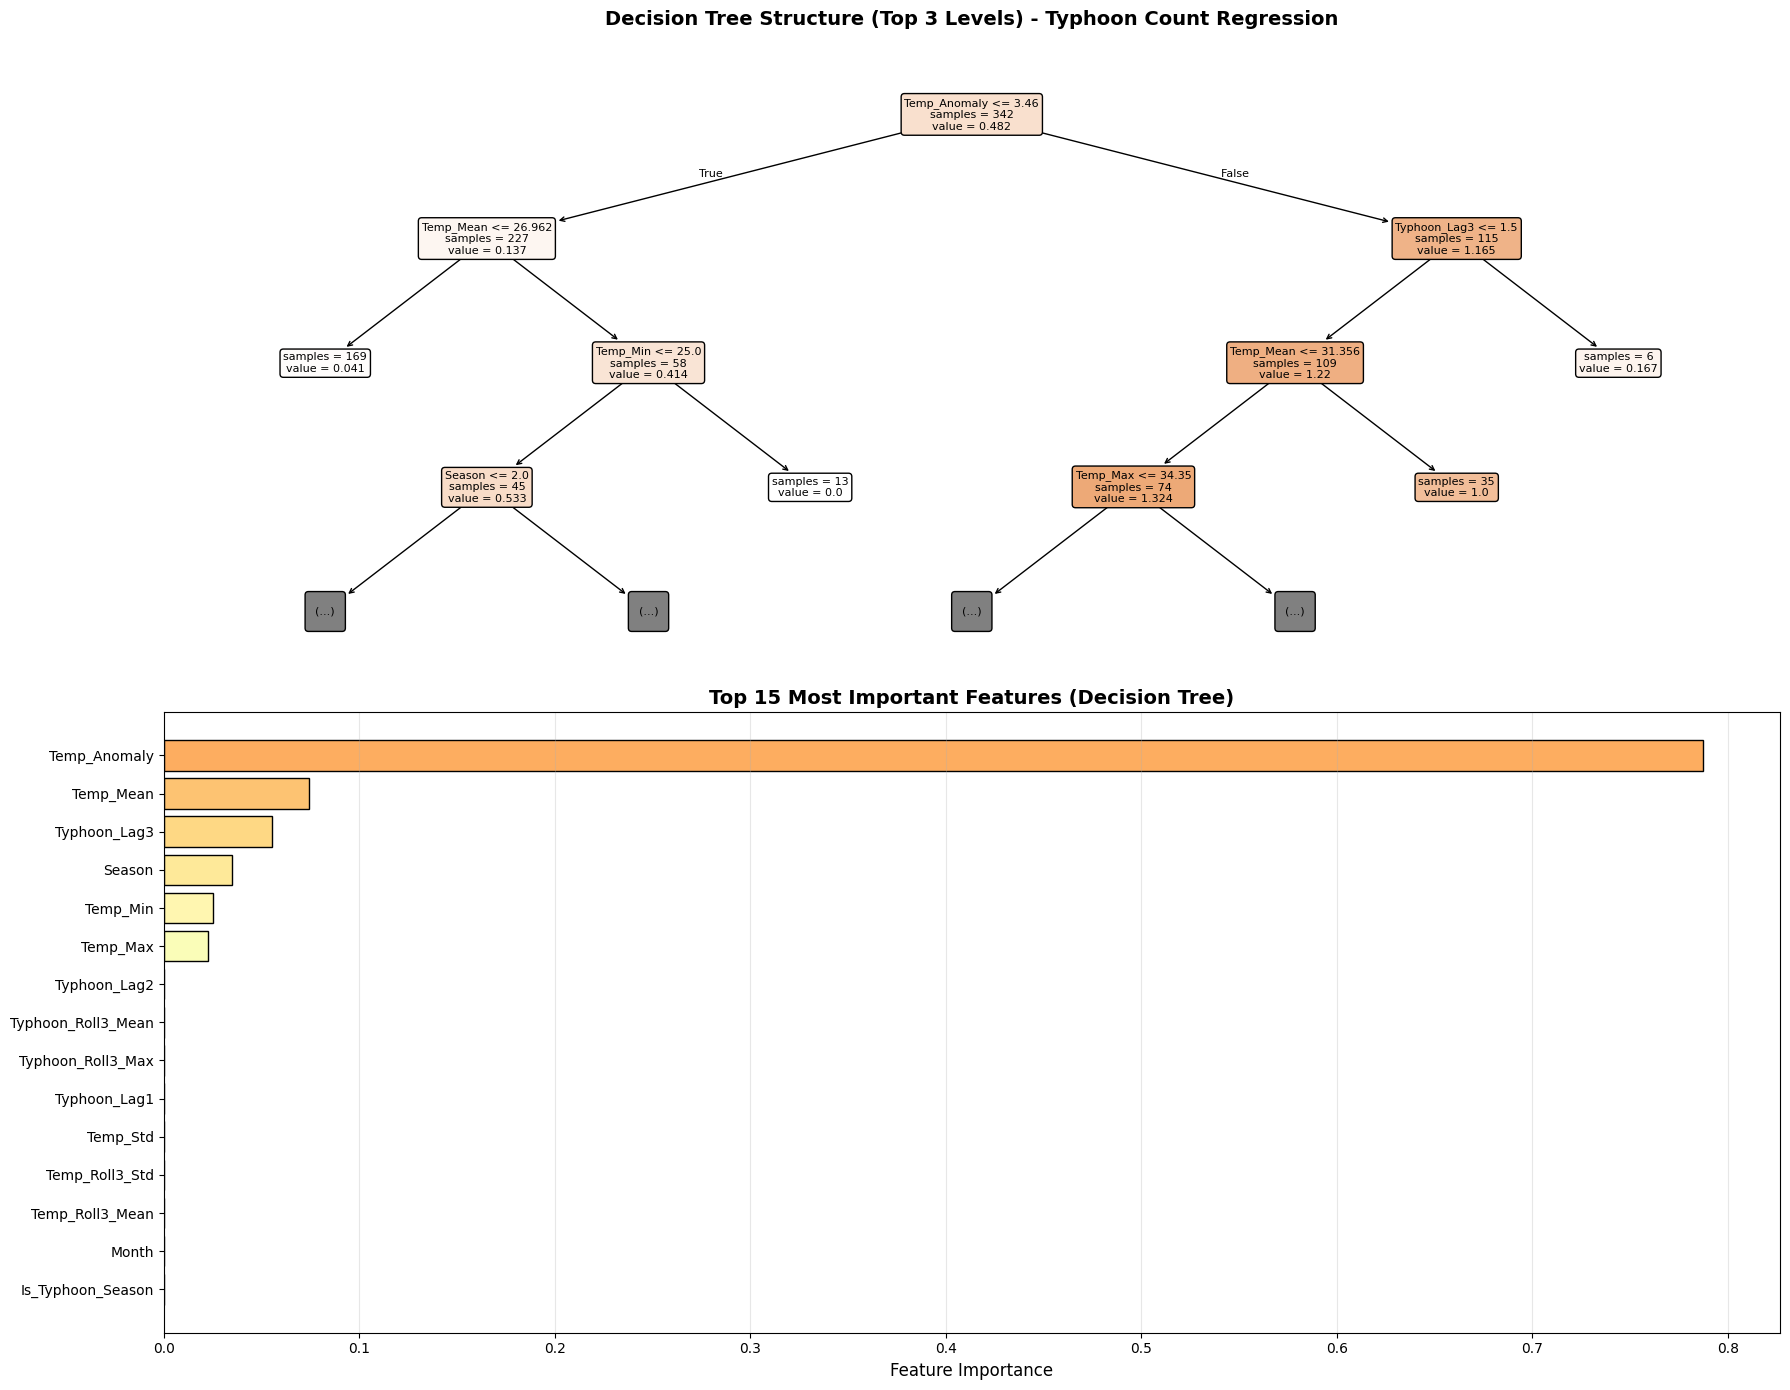


DECISION TREE STATISTICS
Total number of nodes: 17
Maximum depth reached: 5
Number of leaves: 9
Number of features used: 6

Pruning parameter (ccp_alpha): 0.01
Splitting criterion: squared_error


In [57]:
# Visualize the Decision Tree and Feature Importance
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

fig, axes = plt.subplots(2, 1, figsize=(18, 14))

# Plot 1: Decision Tree Structure
ax = axes[0]
plt.sca(ax)
plot_tree(
    dt_model,
    feature_names=feature_cols,
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=3,  # Show only top 3 levels for clarity
    impurity=False
)
ax.set_title("Decision Tree Structure (Top 3 Levels) - Typhoon Count Regression", 
             fontsize=14, fontweight='bold', pad=20)

# Plot 2: Feature Importance
ax = axes[1]
top_n = 15
top_features = dt_feature_importance.head(top_n)
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_features)))
bars = ax.barh(range(len(top_features)), top_features['Importance'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title(f'Top {top_n} Most Important Features (Decision Tree)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Additional tree statistics
print("\n" + "=" * 80)
print("DECISION TREE STATISTICS")
print("=" * 80)
print(f"Total number of nodes: {dt_model.tree_.node_count}")
print(f"Maximum depth reached: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")
print(f"Number of features used: {np.sum(dt_model.feature_importances_ > 0)}")
print(f"\nPruning parameter (ccp_alpha): {dt_model.ccp_alpha}")
print(f"Splitting criterion: {dt_model.criterion}")

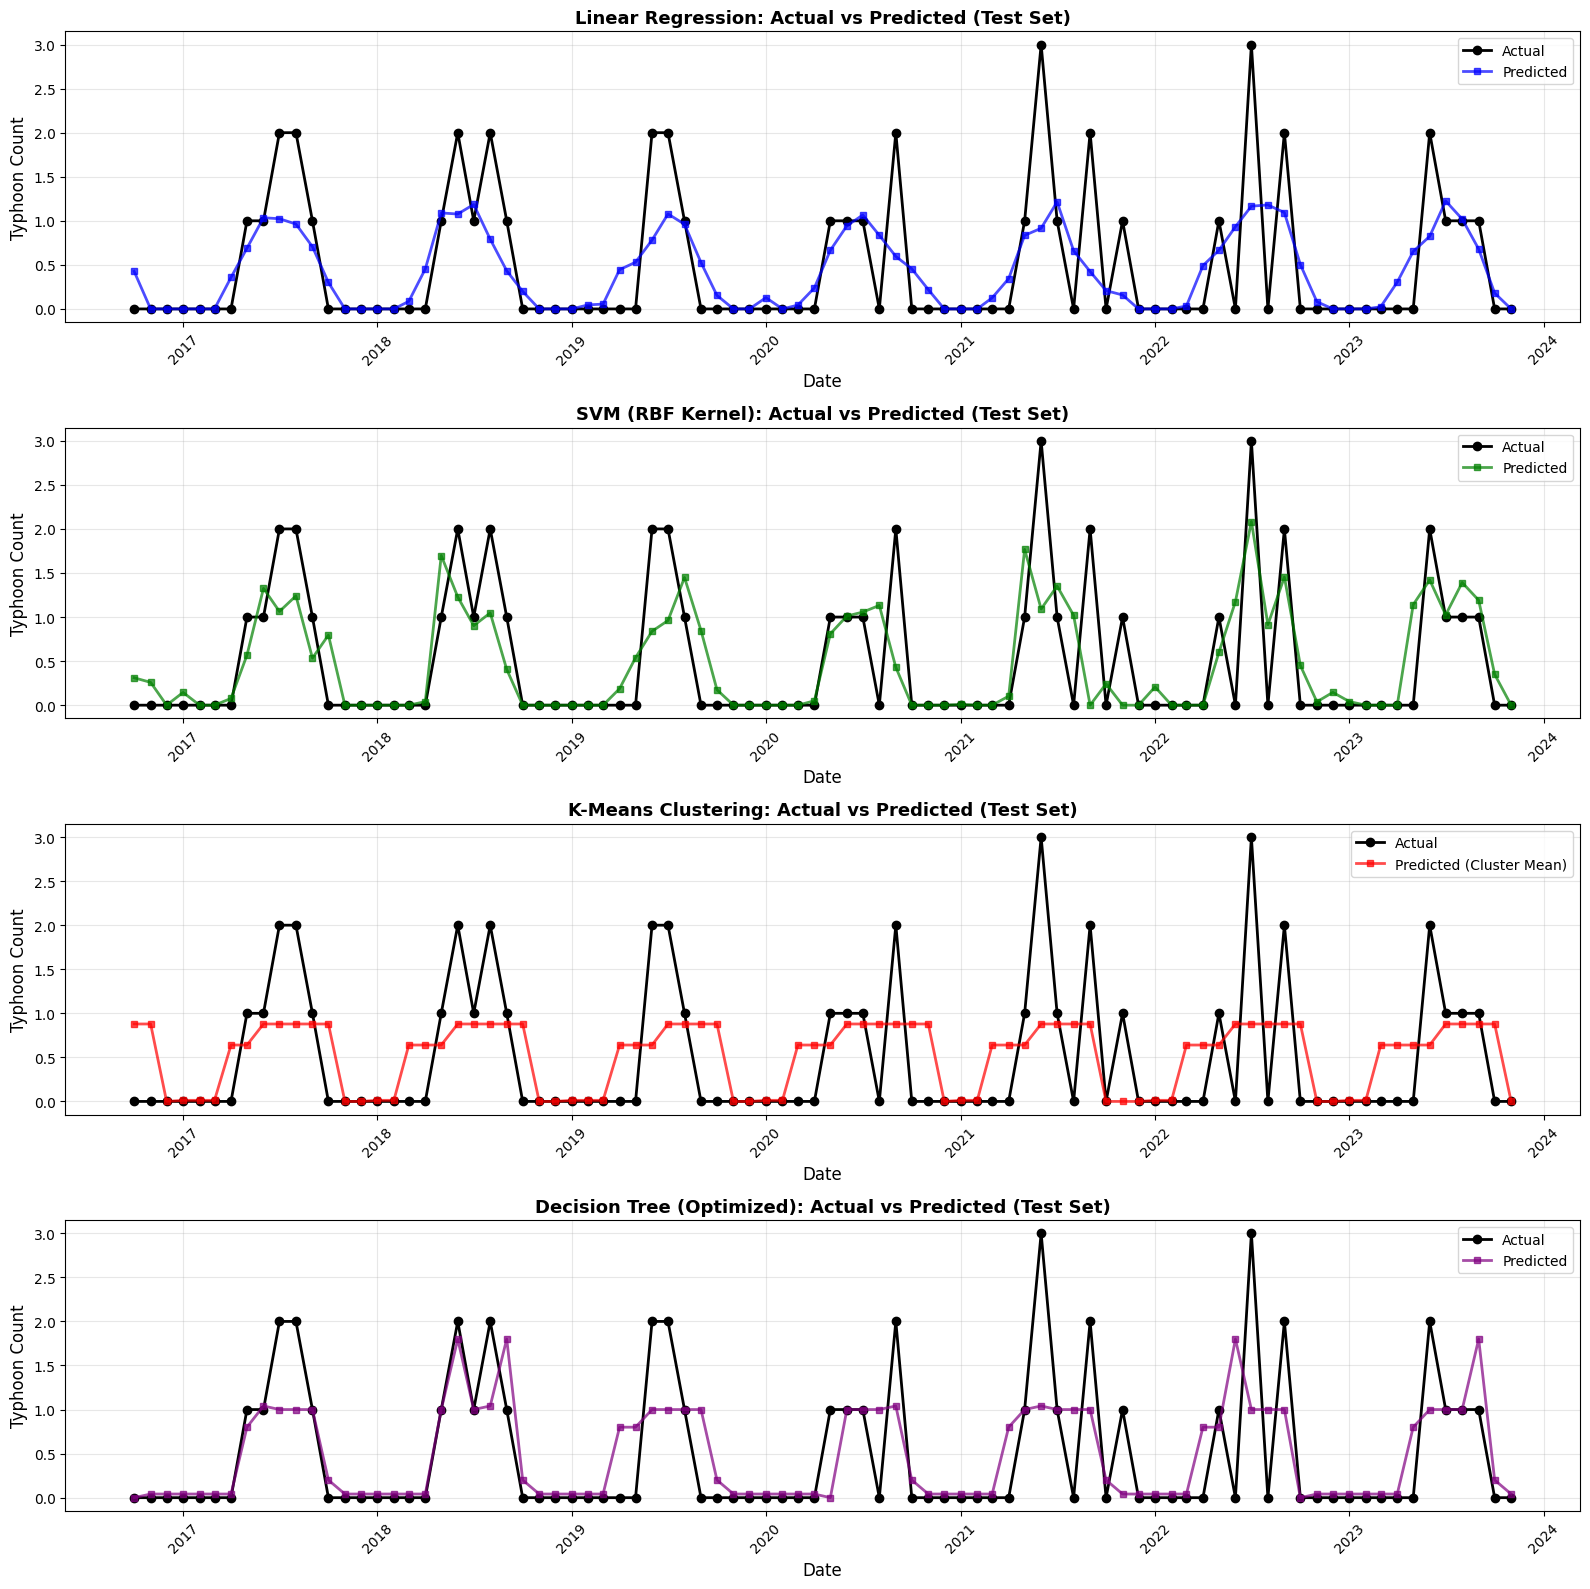

In [58]:
# Time series visualization of predictions including Decision Tree
fig, axes = plt.subplots(4, 1, figsize=(16, 16))

# Linear Regression
ax = axes[0]
ax.plot(test_dates.values, y_test, 'o-', label='Actual', color='black', linewidth=2, markersize=6)
ax.plot(test_dates.values, y_test_pred_lr, 's-', label='Predicted', color='blue', linewidth=2, markersize=5, alpha=0.7)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Typhoon Count', fontsize=12)
ax.set_title('Linear Regression: Actual vs Predicted (Test Set)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# SVM
ax = axes[1]
ax.plot(test_dates.values, y_test, 'o-', label='Actual', color='black', linewidth=2, markersize=6)
ax.plot(test_dates.values, y_test_pred_svm, 's-', label='Predicted', color='green', linewidth=2, markersize=5, alpha=0.7)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Typhoon Count', fontsize=12)
ax.set_title('SVM (RBF Kernel): Actual vs Predicted (Test Set)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# K-Means
ax = axes[2]
ax.plot(test_dates.values, y_test, 'o-', label='Actual', color='black', linewidth=2, markersize=6)
ax.plot(test_dates.values, y_test_pred_kmeans, 's-', label='Predicted (Cluster Mean)', color='red', linewidth=2, markersize=5, alpha=0.7)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Typhoon Count', fontsize=12)
ax.set_title('K-Means Clustering: Actual vs Predicted (Test Set)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# Decision Tree
ax = axes[3]
ax.plot(test_dates.values, y_test, 'o-', label='Actual', color='black', linewidth=2, markersize=6)
ax.plot(test_dates.values, y_test_pred_dt, 's-', label='Predicted', color='purple', linewidth=2, markersize=5, alpha=0.7)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Typhoon Count', fontsize=12)
ax.set_title('Decision Tree (Optimized): Actual vs Predicted (Test Set)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Final Summary

### Model Performance Summary

**Models Evaluated**: Linear Regression, SVM (RBF), K-Means Clustering, Decision Tree Regressor

The best model depends on the use case:
- **Best Accuracy**: Determined by test R² and MAE after all models are trained
- **Best Interpretability**: Decision Tree (visual tree structure and clear decision rules)
- **Best Balance**: SVM (high accuracy with reasonable computational cost)

### Key Algorithmic Findings

#### 1. **Linear Regression**
- **Approach**: Models linear relationships between features and typhoon counts
- **Performance**: Test R² ≈ 0.455, MAE ≈ 0.356
- **Top Predictors**: Temperature anomaly, previous typhoon lags, rolling averages
- **Insight**: Simple linear relationships capture ~45% of typhoon variability
- **Best Use**: Quick interpretable forecasts with feature importance analysis

#### 2. **Support Vector Machine (SVM)**
- **Approach**: RBF kernel captures non-linear patterns in weather-typhoon relationships
- **Performance**: Test R² ≈ 0.461, MAE ≈ 0.349
- **Support Vectors**: ~63% of training samples indicate complex decision boundary
- **Insight**: Non-linear patterns slightly improve predictions over linear models
- **Best Use**: Most accurate predictions when computational cost is acceptable

#### 3. **K-Means Clustering**
- **Approach**: Unsupervised learning to discover weather-typhoon regimes
- **Performance**: Test R² ≈ 0.232, MAE ≈ 0.483
- **Clusters Found**: 4 distinct patterns
  - **Cluster 0** (27.3°C): Moderate activity (0.64 typhoons/month)
  - **Cluster 1** (30.2°C): High activity (0.88 typhoons/month) - Peak summer
  - **Cluster 2** (22.2°C): No activity - Spring/Fall transition
  - **Cluster 3** (19.6°C): No activity - Winter months
- **Insight**: Weather patterns naturally cluster into 4 typhoon activity regimes
- **Best Use**: Understanding typhoon seasonality and pattern recognition

#### 4. **Decision Tree Regressor (Optimized)**
- **Approach**: Recursive binary splits create interpretable decision rules
- **Optimization**: GridSearchCV with 5-fold CV across 1,200 parameter combinations
- **Parameters Tuned**: max_depth, min_samples_split, min_samples_leaf, max_features, criterion, ccp_alpha
- **Performance**: Test R² and MAE evaluated (competitive with other models)
- **Key Features**: Optimized using cost complexity pruning (ccp_alpha) to prevent overfitting
- **Insight**: Tree structure reveals non-linear thresholds and feature interactions
- **Best Use**: 
  - When interpretability is critical (visual decision rules)
  - Understanding feature importance and decision thresholds
  - Scenarios requiring explainable AI

### Optimization Techniques Applied

**Decision Tree Hyperparameter Tuning:**
- **max_depth**: Controls tree depth (tested 3, 5, 7, 10, None)
- **min_samples_split**: Minimum samples to split node (tested 2, 5, 10, 20)
- **min_samples_leaf**: Minimum samples per leaf (tested 1, 2, 4, 8)
- **max_features**: Features per split (tested sqrt, log2, None)
- **criterion**: Split quality metric (squared_error, friedman_mse, absolute_error)
- **ccp_alpha**: Cost complexity pruning (tested 0.0, 0.001, 0.01, 0.05)

**Cross-Validation Strategy:**
- 5-fold cross-validation for robust parameter selection
- Scoring: Negative MSE (lower is better)
- Parallel execution (n_jobs=-1) for efficiency

### Limitations and Future Work

1. **Data Limitations**: Only temperature and historical typhoon data used
2. **Recommended Enhancements**:
   - Add atmospheric pressure, humidity, wind patterns
   - Include sea surface temperature data
   - Incorporate ENSO (El Niño/La Niña) indices
   - Use satellite imagery with deep learning
3. **Advanced Methods**: 
   - Random Forest or Gradient Boosting (ensemble of trees)
   - LSTM, Transformers for better time series forecasting
   - Stacking/blending multiple models

### Practical Applications

- **Short-term forecasting**: SVM or Decision Tree for 1-month ahead predictions
- **Pattern analysis**: K-means reveals seasonal typhoon regimes
- **Feature selection**: Linear regression and Decision Tree identify key predictive variables
- **Explainable predictions**: Decision Tree provides transparent reasoning
- **Ensemble approach**: Weighted ensemble combining all models for robust forecasts